# Тестовое задание
Дан видеофайл crowd.mp4. 


Нужно написать программу на языке Python (или C/C++), которая будет выполнять детекцию людей и их отрисовку на этом видео. 


Результатом должен быть рабочий код программы и видеоролик с отрисованными людьми.


Выполнил: 
[Булыгин Глеб Александрович](https://github.com/gbull25)

Импортируем необходимые библиотеки:

In [1]:
import cv2
import os
import subprocess
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import ultralytics
from ultralytics.utils.checks import check_imshow
from ultralytics.utils.plotting import Annotator, colors
from IPython.display import Video
#from ipywidgets import Video
from collections import defaultdict

### Небольшое описание исходного видео
На тестовом видео оживленная улица с толпой туристов. Некоторые люди двигаются, некоторые стоят и рассматривают товары на прилавках. Съемка ведется с дороги (вероятно из авто), поэтому ракурс не самый удачный. Особенно если мы хотим точно идентифицировать не только наличие человека в области интереса (ROI задачи), но и, например, посчитать людей, или идентифицировать каждого (дать каждому человеку уникальный id).

Трекать людей тоже будет сложно, так как камера двигается в сторону движения людей. Но все равно можно будет попробовать.

### Попробуем справиться с задачей с помощью классических методов

Для этого мы воспользуемся фреймворком OpenCV и достанем из каждого фрейма видео фичи с помощью HOG (Гистограммы направленных градиентов). Обычно полученные фичи прогоняют через линейную модель SVM (Support Vector Machine), которая довольно долго обучается, ну и результаты классификации не всегда радуют. Однако такое решение все равно можно использовать как бейзлайн.

Я уже работал с HOG в паре с SVM в своем учебном проекте про классификацию дорожных знаков. Приглашаю вас посмотреть, что там на сегодняшний день сделано, можно пролистать картинки в ридми. 

[Вот ссылка](https://github.com/gbull25/signs-classification) :) 


Я использую кодек VP90 для того, чтобы видео можно было вставить в ноутбук (*MP4V не открывается). Однако запись в этот кодек в 2-3 раза дольше, чем в *MP4V. Поэтому для прогона оставляю более быстрый кодек.

In [2]:
# Initialize the HOG descriptor/person detector
hog = cv2.HOGDescriptor()
hog.setSVMDetector(cv2.HOGDescriptor_getDefaultPeopleDetector())

cv2.startWindowThread()

# Open test video
cap = cv2.VideoCapture('crowd.mp4')
assert cap.isOpened(), "Error reading video file"

# Reading size of video and frames per second
w, h, fps = (int(cap.get(x)) for x in (cv2.CAP_PROP_FRAME_WIDTH, 
                                       cv2.CAP_PROP_FRAME_HEIGHT, 
                                       cv2.CAP_PROP_FPS))

# We resize output video to match size in detection
# pipeline, otherthise it won`t work.
# The output will be written to output_opencv.mp4.
output_name = "output_HOG.mp4"
result = cv2.VideoWriter("output_HOG.mp4",
                         cv2.VideoWriter_fourcc(*"MP4V"),
                         fps,
                         (int(w*0.5),int(h*0.5)))


# reading the video stream
while cap.isOpened():
    success, frame = cap.read()
    if success:
        # Resizing for faster detection
        frame = cv2.resize(frame, (int(w*0.5),int(h*0.5)))
        # Using a greyscale picture for faster detection
        gray = cv2.cvtColor(frame, cv2.COLOR_RGB2GRAY)

        # Detect people in the image
        # returns the bounding boxes for the detected objects
        boxes, weights = hog.detectMultiScale(frame, winStride=(8,8))

        boxes = np.array([[x, y, x + w, y + h] for (x, y, w, h) in boxes])

        for (xA, yA, xB, yB) in boxes:
            # Display the detected boxes in the colour picture
            cv2.rectangle(frame, (xA, yA), (xB, yB),
                            (0, 255, 0), 2)
        
        # Write the output video 
        result.write(frame)
        # Display the resulting frame
        # Uncomment this for real-time detection video!
        #cv2.imshow('frame',frame)
        if cv2.waitKey(1) & 0xFF == ord("q"):
            break
    else:
        break

# When everything is done, release the capture
cap.release()
# and release the output
result.release()
# finally, close the window
cv2.destroyAllWindows()
cv2.waitKey(1)
print(f'Done, video with bboxes saved here: {output_name}')

Done, video with bboxes saved here: output_HOG.mp4


Получилось неплохо, но детектор пропустил человека в начале видео, который спрятался в товарах, есть несколько ложных срабатываний в районе дорожного знака. 

На некоторых кадрах видно, что ббоксы не совсем точно охватывают объект, IOU для них получился бы не очень хороший.

Конечно, будь у нас информация о лейблах, например, покадровая аннтотация bbox-ов всех объектов, мы бы смогли действительно посчитать какие-нибудь метрики. 

Но так как разметка даже такого короткого видео займет у меня пару дней, придется оценивать результаты на глаз :(

Text(0.5, 1.0, 'Попытка вручную разметить видео в CVAT, чтобы посчитать метрики')

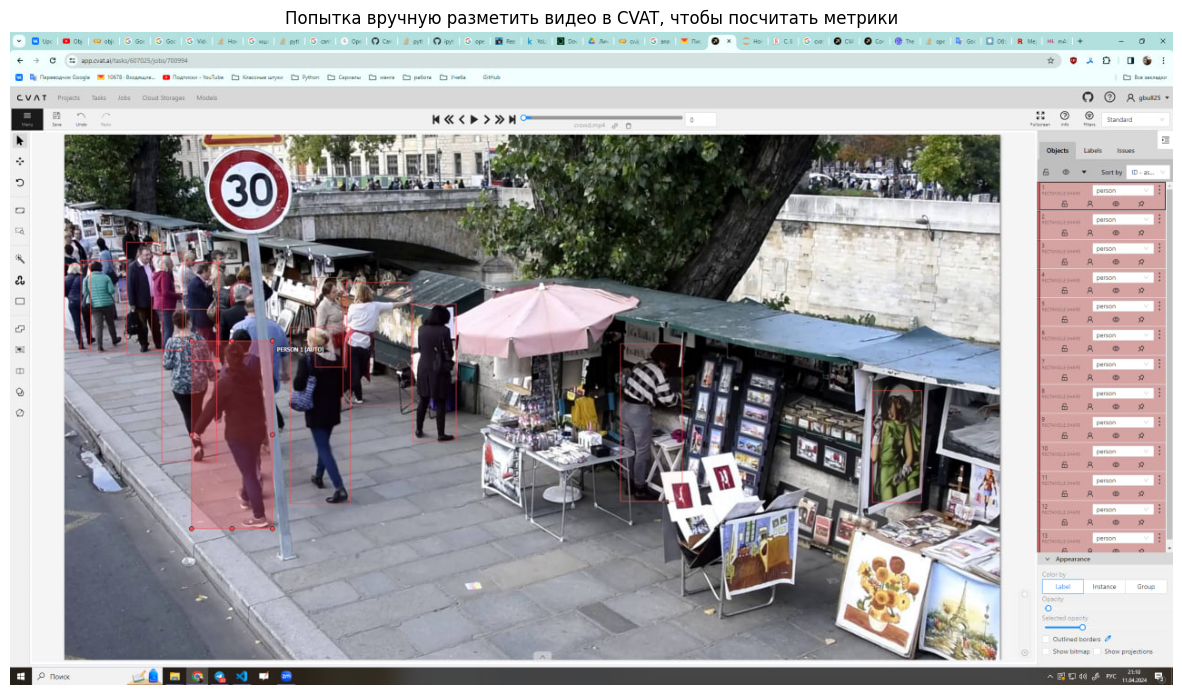

In [2]:
img = cv2.imread('data/cvat-test.jpg') 
plt.figure(figsize=(15,10))
plt.axis('off')
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.title('Попытка вручную разметить видео в CVAT, чтобы посчитать метрики')

### Теперь попробуем использовать DL подход 

Импортируем претрейн YOLOv8 из библиотеки ultralytics. Импортированная модель обучена на датасете COCO, и является самой быстрой и легкой (но не точной) из доступных в библиотеке. YOLOv8 умеет детектировать очень много разных типов объектов, но для нашего задания нужно находить на кадре только людей. Поэтому остальные классы, которые модель увидит на видео, нужно отфильтровать. Также в этом случае можно пренебречь ресайзом видео, модель работает очень быстро (по сравнению с SVM). В качестве трекера мне захотелось попробовать Byte Track. Честно признаться, разницы с дефолтным на этом видео не заметил никакой.

In [105]:
# dictionary with track objects
track_history = defaultdict(lambda: [])
# Define the YOLO model
model = ultralytics.YOLO("yolov8n.pt")

# Open test video
cap = cv2.VideoCapture("crowd.mp4")
assert cap.isOpened(), "Error reading video file"

# Reading size of video and frames per second
w, h, fps = (int(cap.get(x)) for x in (cv2.CAP_PROP_FRAME_WIDTH, 
                                       cv2.CAP_PROP_FRAME_HEIGHT, 
                                       cv2.CAP_PROP_FPS))

output_name = "output_yolov8.mp4"
result = cv2.VideoWriter(output_name,
                        cv2.VideoWriter_fourcc(*"MP4V"),
                       fps,
                       (w, h))

# reading the video stream
while cap.isOpened():
    success, frame = cap.read()
    if success:
        # Initialize tracking with classes=0 (only persons)
        results = model.track(frame, persist=True, verbose=False, tracker="bytetrack.yaml", classes=0)
        boxes = results[0].boxes.xyxy.cpu()

        if results[0].boxes.id is not None:

            # Extract prediction results
            clss = results[0].boxes.cls.cpu().tolist()
            track_ids = results[0].boxes.id.int().cpu().tolist()
            confs = results[0].boxes.conf.float().cpu().tolist()

            # Annotator Initialize
            annotator = Annotator(frame, line_width=2)

            for box, cls, track_id in zip(boxes, clss, track_ids):
                annotator.box_label(box, color=colors(int(cls), True), label='person')

                # Store tracking history
                track = track_history[track_id]
                track.append((int((box[0] + box[2]) / 2), int((box[1] + box[3]) / 2)))
                if len(track) > 30:
                    track.pop(0)

                # Plot tracks
                points = np.array(track, dtype=np.int32).reshape((-1, 1, 2))
                cv2.circle(frame, (track[-1]), 7, colors(int(cls), True), -1)
                cv2.polylines(frame, [points], isClosed=False, color=colors(int(cls), True), thickness=2)

        result.write(frame)
        if cv2.waitKey(1) & 0xFF == ord("q"):
            break
    else:
        break



# When everything is done, release the capture
cap.release()
# and release the output
result.release()
# Close the window
cv2.destroyAllWindows()
cv2.waitKey(1)
print(f'Done, video with bboxes saved here: {output_name}')

Done, video with bboxes saved here: output_yolov8.mp4


Как видим, YOLO справляется с задачей чуть получше. Да, тоже есть ложное захватывание (человек на картине), не все люди в каждом конкретном кадре детектируются. Человек, спрятанный в товарах, задетектировался не сразу.

Однако общее качество детекции на высоте, ббоксы хорошо описывают объекты.


### Можно посмотреть, как выглядят фичи сверточных слоев внутри сетки:

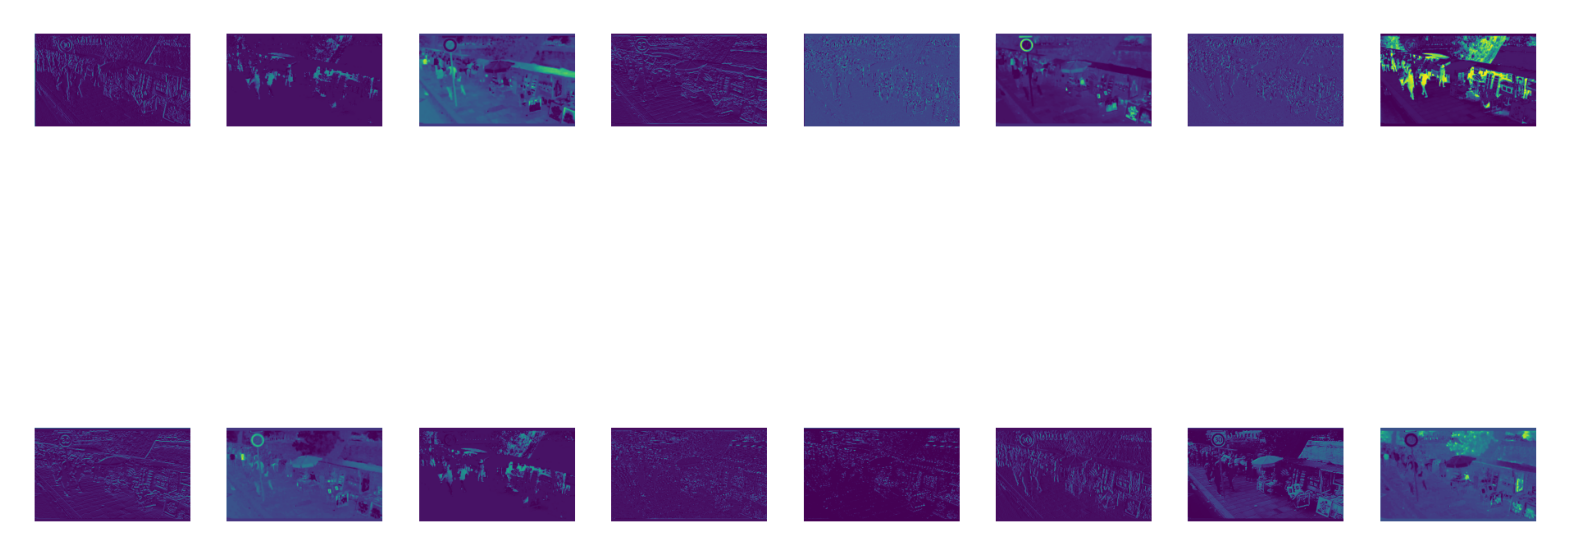

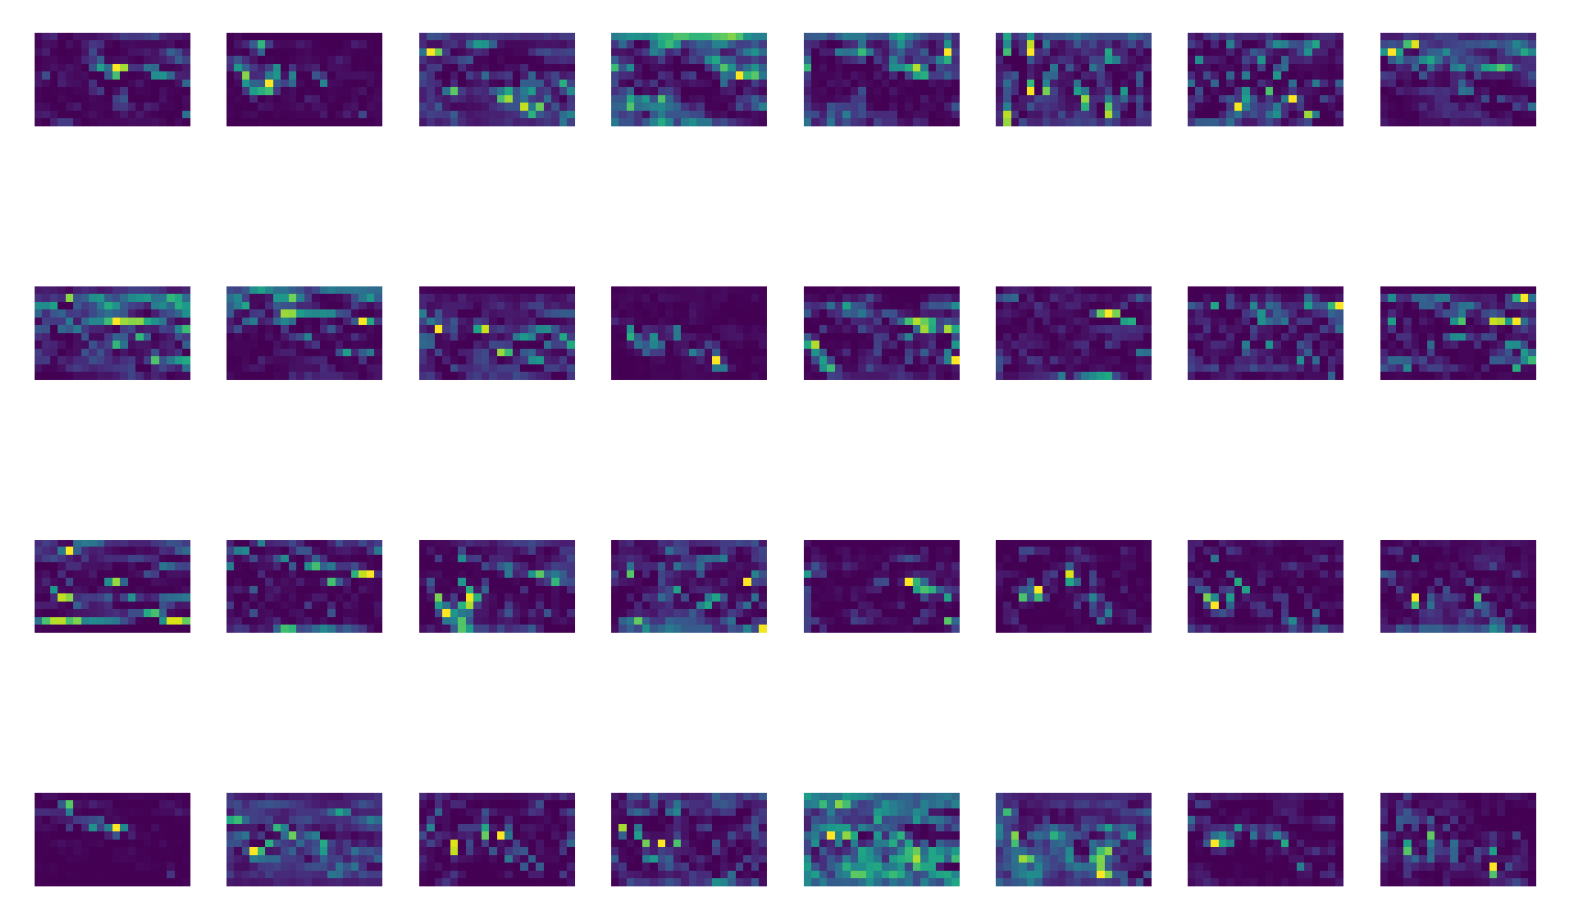

In [3]:
img = cv2.imread('data/stage0_Conv_features.png') 
plt.figure(figsize=(20,15))
plt.axis('off')
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

img2 = cv2.imread('data/stage19_Conv_features.png')
plt.figure(figsize=(20,15))
plt.imshow(cv2.cvtColor(img2, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()

# Вывод

С помощью готовых средств задача детекции людей решается довольно просто, как видно выше. Если бы стояла задача найти на изображениях или видео какие-то редко встречающиеся в датасетах объекты или животных (как в этой [статье](https://habr.com/ru/companies/yandex/articles/786560/)), было бы, конечно, куда сложнее.

В директории data есть текстовый файл с результатами детекции (ббоксы объектов).

Честно говоря, эта задачка мне очень понравилась, теперь хочется собрать сервис или API, который будет предоставлять информацию о присутствии и количестве людей на фото и видео.